# 1. Model

## Erstes Dataset laden

In diesem Notebook wird das erste Pytorch-Modell trainiert. Das Training basiert auf Basis des [nn-Modules](https://pytorch.org/docs/stable/generated/torch.nn.Module.html), eine Art Basis-Modul das allen Neuralen Netzwerken in Pytorch zugrundeliegt.

Auf das Nutzen bereits vortrainierter Module wird zunächst verzichtet

Zunächst erfolgt der Import der benötigten Module

In [5]:
import torch            #PyTorch
from torch import nn    #nn = neural network

import torchvision
from torchvision.datasets.coco import CocoDetection     #zum Laden des COCO-Datensatzes
from torchvision.transforms import ToTensor     #zum Umwandeln der Bilder in Tensoren
from torch.utils.data import random_split       #zum Aufteilen der des datasets in Trainigs- und Testdaten
from torchvision import transforms              #zum Transformieren der Bilder
from torch.utils.data import Dataset        #zum Erstellen eines eigenen Datasets

import matplotlib.pyplot as plt         #zum Anzeigen der Bilder
import matplotlib.patches as patches    #zum Anzeigen der Bounding Boxen


Die Annotaionen wurden mit Labelstudio angefertigt und in einer COCO-Datei gespeichert. 

Für das Auslesen der COCO-Datei existiert in PyTorch die `COCODataset`-Klasse. Mit `CocoDetection` können die Bilder über `root="01_annotation"` geladen und in einem `dataset` abgelegt werden. `01_annotation` ist in diesem Fall der Ordner, in dem sich der Ordner für die Bilder `images` und die JSON-Datei `result.json` befinden.

Das der Pfad zu den Bildern nicht `root="01_annotation/images"` lautet, liegt darin begründet, dass die JSON-Datei `result.json` mit den Annotationen bereits den relativen Pfad zu den Bildern enthält. Dieser steht gleich an erster Stelle in der Datei und lautet `images`. Somit werden die Bilder zu den Annotationen immer in einem Ordner `images` gesucht, der sich im selben Verzeichnis wie die JSON-Datei befindet. Würde der Pfad dennoch mit `root="01_annotation/images"` angegeben, würde `CocoDetection` nach dem Pfad `root="01_annotation/images/images"` suchen, was folglich zu einer Fehlermeldung führen würde.

Somit muss nicht nur der relative Pfad beibehalten werden, sondern auch die Bezeichnung des Bild-Ordners. Andernfalls wäre es notwendig den Pfad innerhalb der JSON-Datei anzupassen.

Die JSON-Datei `result.json` wird über den klassichen Pfad `annFile="01_annotation/result.json"` geladen.

`transform=ToTensor()` wandelt die geladenen Bilder sofort in Tesoren um, während `target_transform=None` die Tensor-Transformation für die Annotationen zunächst verhindert. `transforms.Grayscale(num_output_channels=1)` reduziert die Farbinformationen der Bilder auf Graustufen. Eine diesbezügliche Erklärung folgt in Kürze.

Die `transforms.ToTensor()` Transformation konvertiert ein PIL-Bild oder ein numpy.ndarray (H x W x C) im Bereich [0, 255] in ein torch.FloatTensor im Bereich [0.0, 1.0] mit der Form (C x H x W).

In [6]:
dataset = CocoDetection(
                        root="01_annotation",
                        annFile="01_annotation/result.json",
                        transform=transforms.Compose([
                                                    transforms.ToTensor(),
                                                    transforms.Grayscale(num_output_channels=1),
                                                    ]),
                        target_transform=None)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


`dataset` liefert einige Informationen über das erstellte Dataset. So wird ersichtlich, dass alle 48 Bilder als Objekte vorhanden sind.

In [7]:
dataset

Dataset CocoDetection
    Number of datapoints: 48
    Root location: 01_annotation
    StandardTransform
Transform: Compose(
               ToTensor()
               Grayscale(num_output_channels=1)
           )

Der nachstehende Code lädt das erste Bild und die zugehörigen Annotationen aus dem `dataset`-Objekt und weißt sie den Variablen `img` und `label` zu

In [8]:
img, label, = dataset[0]

## Bilder

Da das Bild beim Erstellen des `datasets` transformiert wurde, ist der `type` bereits ein Tensor.

`shape` liefert Informationen über die Struktur des Tensors. Das angegebene Format repräsentiert die Werte [channels, height, width]. Während letztere für die Bildmaße stehen, gibt der erste Wert die Farbchannels an. Dieser beträgt 1, da die Farbinformationen zuvor auf Graustufen reduziert wurden. Somit kann jeder Pixel nur noch einen Wert zwischen 0 (schwarz) und 255 (weiß) annhemen.

Vor der Trasformation hätte der Wert 3, für den RGB-Farbraum, betragen und `shape` hätte die Werte `[3, 1383, 1000]` zurückgegeben. Das die Bilder auch zuvor schwarz-weiß waren, macht dabei keinen Unterschied. Graustufen werden im RGB-Farbraum durch drei identische Werte repräsentiert (z.B. 139, 139, 139).

Finden mit den Tensoren im weiteren Verlauf Berechnungen statt, müssten für einen Tensor im RGB-Farbraum 3 * 1383 * 1000 = 4.149.000 Elemente in die Berechnung einbezogen werden, wohingegen es mit Graustufen nur 1 * 1383 * 1000 = 1.383.000 Elemente sind. Der Rechenaufwand sollte durch die Reduzierung des Farbraums also ungefähr gedrittelt werden.

In [9]:
type(img), img.shape

(torch.Tensor, torch.Size([1, 1383, 1000]))

Der vollständige Tensor lässt sich einfach über die `img`-Variable ausgeben.

In [10]:
img

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0039, 0.3451],
         [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0039, 0.3451],
         [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0039, 0.3451],
         ...,
         [0.5215, 0.5215, 0.5215,  ..., 0.5215, 0.5215, 0.5215],
         [0.5215, 0.5215, 0.5215,  ..., 0.5215, 0.5215, 0.5215],
         [0.5215, 0.5215, 0.5215,  ..., 0.5215, 0.5215, 0.5215]]])

Mit der `imshow`-Funktion von matplotlib kann der Tensor als Bild angezeigt werden.

Die `squeeze`-Funktion entfernt alle Dimensionen der Größe 1 aus dem Tensor. Da sich ohnehin nur noch ein Farbkanal in dem Tensor befindet, macht der Wegfall der dieser Information keinen Unterschied. Wird kein Kanal angegeben, geht die `imshow`-Funktion automatisch von einem Bild in Graustufen aus. Der Tensor wird zweidimensional.

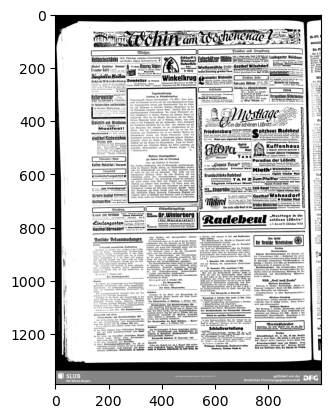

In [65]:
plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Nun könnte Frage aufkommen, woher die Farbinformationen kommen, wenn der Farbkanal entfernt wird. Der Farbkanal gibt aber nicht an, welchen Farbwert ein Pixel hat, sondern wie dieser Wert interpretiert wird. Der Helligkeitswert jedes Pixels eines dreidmimensionalen Tensors kann über folgenden Zeile ausgegeben werden:

In [12]:
img[0,134,357]

tensor(0.0078)

0.0078 ist der Helligkeitswert des Bildpixels an der Stelle 133 vertikal und 356 hochizontal. Die Null repräsentiert lediglich auf welchen Farbraum dieser Helligkeitswert angewandt werden soll. Hier grau, der einzige Farbkanal, wodurch die 0 nur eine Art Platzhalter ist.

Somit bleiben alle Informationen auch dann erhalten, wenn der Pixel in Verbindung mit der `squeeze`-Funktion aufgerufen wird. 


In [13]:
img.squeeze()[134,357]

tensor(0.0078)

### Farb-Exkurs


Deutlicher wird die Struktur an einem Tensor im RGB-Farbraum. Als Beispiel kann ein Tensor mit vier Pixeln erstellt werden. 

Jede der untenstehenden Klammern repräsentiert einen der drei Farbräume. Die vier Werte in den Klammern stehen für die Helligkeit des Pixels im entsprechenden Farbraum. Die ersten drei Pixel werden rot, grün, blau eingefärbt indem der Wert des Pixels im entsprechenden Kanal auf das Maximum (255) gesetzt wird. Alle anderen Werte des Pixels verbleiben 0.

Der letzte Pixel wird grau gefärbt, indem alle Pixel den Wert 100 erhalten.

In [14]:
farb_tensor = torch.tensor([
    [[255, 0],   # rot
     [0, 100]],

    [[0, 255],   # grün
     [0, 100]],

    [[0, 0], # blau
     [255, 100]]
], dtype=torch.uint8)

`shape` zeigt nun die drei Farbkanäle und zwei Pixel in Höhe und Breite

In [15]:
farb_tensor.shape

torch.Size([3, 2, 2])

Mit matplotlib lässt sich das erstellte "Bild" ebenfalls darstellen.

Die `numpy().transpose((1, 2, 0))`-Funktion stellt die Farbkanäle lediglich an das Ende, da matplotlib diese Information als letztes erwartet.

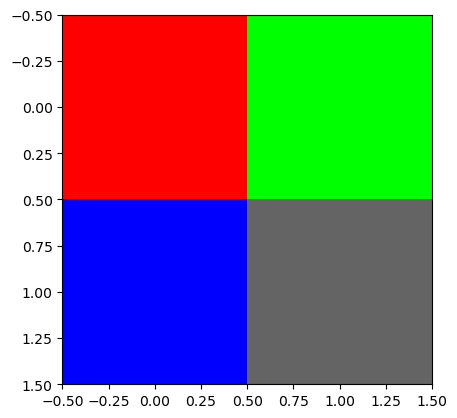

In [16]:
numpy_img = farb_tensor.numpy().transpose((1, 2, 0))

plt.imshow(numpy_img)
plt.show()

Wird nun der erste Pixel des Tensors aufgerufen, ist die Wahl des Kanals durchaus von Bedeutung. Für den ersten Kanal wird 255 ausgegeben, wie für die Farbwahl rot festgelegt. Die beiden anderen Kanäle haben entsprechend den Wert 0.

In [17]:
farb_tensor[0, 0, 0],   farb_tensor[1, 0, 0],   farb_tensor[2, 0, 0]
#rot                    grün                    blau

(tensor(255, dtype=torch.uint8),
 tensor(0, dtype=torch.uint8),
 tensor(0, dtype=torch.uint8))

Der graue Pixel zeigt für jeden Kanal den Wert 100.

In [18]:
farb_tensor[0, 1, 1], farb_tensor[1, 1, 1], farb_tensor[2, 1, 1]

(tensor(100, dtype=torch.uint8),
 tensor(100, dtype=torch.uint8),
 tensor(100, dtype=torch.uint8))

## Annotationen

Die Annotationen zu den Bildern sind noch in Listenform. Genauer gesagt, sind alle Annotationen (`label`) eines Bildes in einer Liste abgelegt, die ihrerseits Dictionaries enthält. Jedes Dictionary steht wiederum für eine Annotation, die dem Bild hinzugefügt wurde. 

Die Anzahl der Dictionaries entspricht also der Anzahl der *bounding boxen*, die auf dem Bild platziert wurden, um die Überschriften zu markieren. In diesem Fall sind es 13 Annotationen.

In [19]:
type(label), len(label)

(list, 13)

Derzeit sind jedoch für jede Annotation weit mehr Informationen vorhanden, als für das anschließende Training benötigt werden. Genauer gesagt 8.

In [20]:
label

[{'id': 0,
  'image_id': 0,
  'category_id': 2,
  'segmentation': [],
  'bbox': [46.42077096632242,
   334.254011276776,
   535.1069479220117,
   40.1705687000941],
  'ignore': 0,
  'iscrowd': 0,
  'area': 21495.550413398847},
 {'id': 1,
  'image_id': 0,
  'category_id': 2,
  'segmentation': [],
  'bbox': [88.00909090909094,
   449.3406322362973,
   339.58229587969157,
   28.422391350349667],
  'ignore': 0,
  'iscrowd': 0,
  'area': 9651.740909142827},
 {'id': 2,
  'image_id': 0,
  'category_id': 2,
  'segmentation': [],
  'bbox': [441.25184063665,
   447.8901594049977,
   353.69768456436475,
   27.541374559676157],
  'ignore': 0,
  'iscrowd': 0,
  'area': 9741.320411477358},
 {'id': 3,
  'image_id': 0,
  'category_id': 2,
  'segmentation': [],
  'bbox': [48.96847135538128,
   492.3981367467056,
   394.428199499998,
   38.819084252215],
  'ignore': 0,
  'iscrowd': 0,
  'area': 15311.341507839888},
 {'id': 4,
  'image_id': 0,
  'category_id': 2,
  'segmentation': [],
  'bbox': [253.4720

An sich wird nur die Position der *bounding box* `bbox` und die Labelkategorie `category_id`, der die Box zugeordnet ist, benötigt.

In [21]:
images = []
boxes = []
categories = []

for i in range(len(dataset)):
    img, labels = dataset[i]
    images.append(img)
    for label in labels:
        boxes.append(label['bbox'])
        categories.append(label['category_id'])

In [22]:
type(images), type(boxes), type(categories)

(list, list, list)

In [23]:
len(images), len(boxes), len(categories)

(48, 484, 484)

An dieser Stelle sollte es theoretisch nur noch nötig sein, die erstellten Listen in Tensoren zu transformieren. Die Erstellung des Tensor-Images wird aber fehlschlagen, da erst an dieser Stelle auffällt, dass alle Bilder die selbe Höhe und Breite haben müssen, damit sie als Tensoren weiterverarbeitet werden können.

In [24]:
#images = torch.stack(images)
#boxes = torch.as_tensor(boxes)
#categories = torch.as_tensor(categories)

## Padding

Ein erneutes Skalieren der Bilder ist an dieser Stelle nicht mehr möglich. da sonst die Bounding Boxen nicht mehr auf die Bilder passen würden. Die Bilder können jedoch beliebig nach rechts in der Breite und nach unten in der Höhe vergrößert werden, da die Bounding Boxen anhand der linken oberen Bildecke ausgerichtet werden.

Padding ermöglicht das Hinzufügen einer beliebigen Anzahl von Pixeln zu jeder Bildseite. Obwohl dieses Verfahren die erforderliche Rechenleistung erhöht, ist es derzeit der einfachste Weg, die Tensoren zu vereinheitlichen. Das Entfernen von Pixeln ist leider nicht möglich. Generell ist es daher empfehlenswert, die Bilder gleich zu Beginn anzugleichen.

Der erste Schritt ist die Bestimmung der Höhen der einzelnen Bilder. Diese könne erneut aus der `result.json`-Datei entnommen und in der Liste `heights` abgelegt werden.


In [25]:
import json
heights = []

with open("01_annotation/result.json") as f:
    data = json.load(f)

for image in data['images']:
    heights.append(image['height'])
    

Anschließend wird der größte Werte der `heights`-Liste ausgegeben, wodurch ersichtlich wird, dass alle Bilder eine Höhe von 1421 Pixeln benötigen.

In [26]:
max(heights)

1421

Somit müssen zu dem kleinsten Bild 53 Pixel in der Höhe hinzugefügt werden.

In [27]:
max(heights) - min(heights)

53

Für die Bildbearbeitung stellt `torchvision` das `functional`-Modul zur Verfügung. In dem Modul befinden sich diverse Funktionen für die Bildmanipulation.

Die Variable `desired_size` enthält die Höhe, auf die alle Bilder zu vereinheitlichen sind.

Mit der `F.pad`-Funktion wird für jedes Bild in der Liste `images` die Höhe aus der Differenz der Bildhöhe (`img.shape[1]`) und der benötigten Höhe (`desired_size`) als Pixel an der Unterseite des Bildes hinzugefügt. Die Werte für die anderen drei Seiten bleiben entsprechend 0.





In [28]:
from torchvision.transforms import functional as F

desired_size = (1421)

images = [F.pad(img, (0, 0, 0, desired_size - img.shape[1])) for img in images]



Nun können alle drei Listen in Tensoren umgewandelt werden.

In [29]:
image_tensor = torch.stack(images)
box_tensor = torch.as_tensor(boxes)
category_tensor = torch.as_tensor(categories)

Der Datentyp stimmt.

In [30]:
type(image_tensor), type(category_tensor), type(box_tensor)

(torch.Tensor, torch.Tensor, torch.Tensor)

Und ein Blick auf die Struktur des Tensors zeigt, dass alle 48 Bilder eine Höhe von 1421 Pixeln haben.

In [31]:
image_tensor.shape, category_tensor.shape, box_tensor.shape

(torch.Size([48, 1, 1421, 1000]), torch.Size([484]), torch.Size([484, 4]))

Sofort offenbart sich aber das nächste Problem. Mit den Tensoren in ihrer jetztigen Form, lassen sich die Annotationen nicht den zugehörigen Bildern zuordnen. Mindestens einer der beiden Annoations-Tensoren benötigt eine Art ID, die beispielweise auf die Bildnummer verweist. Im nächsten Schritt muss daher eine Methode gefunden werden, um die Tensoren miteinander in Beziehung zu setzen.

## Der Index-Tensor

Am naheliegenste Ansatz bestünde darin, den `category_tensor` und den `box_tensor` an die 48er-Struktur des `image_tensor`s anzupassen. Somit könnten die Boxen und ihre zugehörigen Kategorien den Bildern zugeordnet werden. Dieses Vorgehen würde aber unmittelbar zu dem selben Problem führen, das soeben für den `image_tensor` bestand. Da jedes Bild eine unterschiedliche Anzahl an Annoationen besitzt, wäre der Tensor wieder unförmig und müsste mit Platzhalterwerten aufgefüllt werden. Da es aber auch Bilder mit nur einer oder keiner Annotation und andere mit 20 Annotationen gibt, wären im ungünstigsten Fall bis zu 20 Platzhalter-Annotationen notwendig. Das Padding würde die Tensoren zudem enorm aufblähen. Darüber hinaus müssten diese Platzhalter im weiteren Verlauf des Lernprozesses wieder entfernt/ gezielt exkludiert werden.

Ein weitere Option besteht in der Erstellung einer Indize-Liste, die auf die Startposition der Bounding-Boxen und Kategorien für jedes Bild verweißt. Das Ziel ist also eine Liste mit 48 Startwerten. Hierfür wird nochmals die Label-Liste aus der json-Datei herangezogen, aus der zuvor bereits die Annotationen entnommen wurden. Wie bereits geschildert, enthält die Liste für jede Bildannotation ein Dictionary. Mit dem Abrufen der Länge der Annotationsliste wird somit die Anzahl der Annotationen pro Bild angezeigt.

Die Anzahl der Annotationen wird in der Liste `annotation_count` abgelegt. 

In [32]:
annotation_count = []

for i in range(len(dataset)):
    img, labels = dataset[i]
    annotation_count.append(len(labels))
print(annotation_count)
print(len(annotation_count))

[13, 11, 18, 15, 3, 18, 21, 10, 10, 14, 2, 1, 19, 13, 14, 2, 14, 19, 21, 19, 3, 15, 13, 17, 5, 2, 1, 1, 13, 7, 20, 8, 13, 6, 2, 1, 12, 2, 17, 17, 6, 12, 11, 2, 2, 6, 13, 0]
48


Die 48 Werte der Liste `annotation_count` werden anschließend, beginnend bei 0, aufsummiert und jede neue Summe der Liste `indices` hinzugefügt. Diese repräsentiert schließlich die Startposition der Bounding-Boxen und Kategorien für jedes Bild.

In [33]:
indices = []
count = 0
for i in range(len(annotation_count)):
    indices.append(count)
    count += annotation_count[i]

print(indices)

[0, 13, 24, 42, 57, 60, 78, 99, 109, 119, 133, 135, 136, 155, 168, 182, 184, 198, 217, 238, 257, 260, 275, 288, 305, 310, 312, 313, 314, 327, 334, 354, 362, 375, 381, 383, 384, 396, 398, 415, 432, 438, 450, 461, 463, 465, 471, 484]


Auch diese Liste wird für die Weiterverarbeitung in einen Tensor umgewandelt.

In [34]:
indices_tensor = torch.tensor(indices)

Alle Informationen, die für ein erfolgreiches Training notwendig sind, sollten nun in den vier Tensoren im richtigen Format vorhanden sein.

In [35]:
image_tensor.shape, category_tensor.shape, box_tensor.shape, indices_tensor.shape

(torch.Size([48, 1, 1421, 1000]),
 torch.Size([484]),
 torch.Size([484, 4]),
 torch.Size([48]))

## Normalisierung der Daten

Machine-Learning-Algorithmen arbeiten in der Regel besser mit normalisierten Daten. Das bedeutet, dass die Werte in den Tensoren auf Zahlen zwischen 0 und 1 konvertiert werden. Deshalb sind die Bilder, die gleich zu Beginn von PyTorch in Tensoren umgewandelt wurden, auch bereits in normalisierter Form vorhanden.

Die Normalisierung soll auch numerischen Stabilitätsproblemen entgegenwirken. Diese können sowohl bei der Arbeit mit zu großen als auch mit zu kleinen Zahlen auftreten. Ein Beispiel hierfür ist der *explodierende Gradient*. Dieser Effekt kann während des Backpropagation-Prozesses auftreten.

Einfach ausgedrückt ist die Backpropagation der Algorithmus, der die Gewichtungen und Bias-Werte des neuronalen Netzes während des Trainings aktualisiert. Wenn diese Werte zu groß sind, kann dies dazu führen, dass der Gradient exponentiell ansteigt. Dadurch werden die Gewichte extrem erhöht, und das Netzwerk wird instabil, was wiederum dazu führen kann, dass es nicht mehr lernt.

Die Normalisierung des `box_tensors` wird in den folgenden Schritten durchgeführt. Der `category_tensor` muss nicht normalisiert werden, da er im weitesten Sinne Metadaten enthält, die Kontextinformationen über die Bilddaten enthalten.

In [36]:
box_tensor

tensor([[ 46.4208, 334.2540, 535.1069,  40.1706],
        [ 88.0091, 449.3406, 339.5823,  28.4224],
        [441.2518, 447.8902, 353.6977,  27.5414],
        ...,
        [272.7478, 469.5978, 350.7002,  24.4658],
        [129.1189, 116.2684, 232.8887,  20.0168],
        [683.0473, 280.9006, 118.3777,  14.7809]])

Um die Werte zu Normalisieren, werden alle x-Werte durch die Bildweite und alle y-Werte durch die Bildhöhe dividiert.

(Der Code sollte nicht mehrfach ausgeführt werden)

In [37]:
image_width = 1000
image_height = 1421

box_tensor[:, 0] = box_tensor[:, 0] / image_width   # x_min
box_tensor[:, 1] = box_tensor[:, 1] / image_height  # y_min
box_tensor[:, 2] = box_tensor[:, 2] / image_width   # x_max
box_tensor[:, 3] = box_tensor[:, 3] / image_height  # y_max

Somit liegt der Tensor in normalisierter Form vor und es kann mit der Erstellung des Datasets für das Modelltraining begonnen werden

In [38]:
box_tensor

tensor([[0.0464, 0.2352, 0.5351, 0.0283],
        [0.0880, 0.3162, 0.3396, 0.0200],
        [0.4413, 0.3152, 0.3537, 0.0194],
        ...,
        [0.2727, 0.3305, 0.3507, 0.0172],
        [0.1291, 0.0818, 0.2329, 0.0141],
        [0.6830, 0.1977, 0.1184, 0.0104]])

### Alternative Vorgehensweise

Es besteht auch die Möglichkeit, an Stelle von zwei Tensoren `box_tensor` und `category_tensor` mit nur einem `annotation_tensor` weiterzuarbeiten. In diesem Fall würde der `category_tensor` and den `box_tensor` angehängt werden.

**DER CODE SOLL NUR ALS ALTERNATIVE AN DIESER STELLE VERMERKT WERDEN. DAS AUSFÜHREN DER FELDER KANN IM WEITEREN VERLAUF ZU PROBLEMEN FÜHREN!**

In [39]:
#category_tensor = category_tensor.unsqueeze(1)

#annotation_tensor = torch.cat((box_tensor, category_tensor), dim=1)

In [40]:
#annotation_tensor

In [41]:
#annotation_tensor.shape

## Erstellung eines eigenen Datasets

### Exkurs Klassen

PyTorchs Datasets sind Klassen. In Python ist eine Klasse als eine Art Code-Vorlage zu verstehen. Anhand der Vorlage können Objekte zusammen mit anderen Mitgliedsvariablen erstellt werden. Zusätzlich ist es möglich, den Objekten bestimmte Verhaltensweisen zuzuschreiben, die durch Methoden definiert sind.

Mit dem dem Erstellen einer Klasse wird im Grunde ein neuer Datentyp definiert.

Ein Beispiel für eine Klasse:

In [42]:
class Person:
    def __init__(self, name, age):
        self.name = name
        self.age = age

    def greet(self):
        print(f"Hello, my name is {self.name} and I'm {self.age} years old.")

In dem Beispiel wird eine Klasse `Person` mit zwei Attributen `name` und `age` und einer Methode `greet` erstellt.

Die Methode `__init__` wird auch als Konstruktor bezeichnet. Bei `__init__` handelt es sich um eine spezielle Methode, die immer dann aufgerufen wird, wenn ein neues Attribut einer der Klasse erstellt wird. Ein Attribut ist eine Variable, die zu einem Objekt (oder einer Instanz [synonymer Gebrauch]) gehört. Auf Attribute kann über das `self`-Schlüsselwort innerhalb der Klasse zugegriffen werden. Das Schlüsselwort dient als Referenzwert, der verdeutlicht, dass eine Varibale zu einer Instanz der Klasse gehört.

Eine Instanz ist ein einzelnes Objekt einer bestimmten Klasse. Für die obige Klasse wäre eine Instanz beispielsweise der Name und das Alter einer konkreten Person.  die wie folgt erstellt werden können:

In [43]:
alice = Person("Alice", 25)
bob = Person("Bob", 30)

Anders formuliert ist eine Instanz ist ein konkreter Wert des erstellten Klassen-Datentyps.

`alice` und `bob` sind Instanzen der Klasse `Person`. Jede der beiden Instanzen besitzt ihre eigenen Attribute `name` und `age`, die unabhängig von den Attributen der anderen Instanz sind. `name` und `age` der selben Instanz sind zueinander Mitgliedsvariablen.

Die Attribute einer Instanz können nach folgendem Schema aufgerufen werden:

In [44]:
print(alice.name)
print(alice.age)

Alice
25


Mit der zuvor definierten `greet`-Methode, kann über die Syntax `instance.method()` eine Grußformel für jede Instanz der Klasse ausgegeben werden.

In [45]:
alice.greet()
bob.greet()

Hello, my name is Alice and I'm 25 years old.
Hello, my name is Bob and I'm 30 years old.


Mit diesem Wissen kann nun begonnen werden, eine eigene PyTorch-Datasetklasse zu erstellen.

### Das Custom-PyTorch-Dataset

Nachdem das erste Dataset, das von PyTorch aus der COCO-Datei und den Bildern der Zeitungsseiten erstellt wurde, stark verändert und angepasst wurde, müssen die vier Tensoren nun manuell in ein Dataset übertragen und miteinander in Beziehung gesetzt werden.

Herfür können die Tensoren als Attribute in eine benutzerdefinierte Dataset-Klasse übertragen werden, die von der PyTorch Dataset-Klasse erbt. *"Von einer Klasse erben"* bedeutet in dem Zusammenhang, dass die benutzerdefinierte Dataset-Klasse die Eigenschaften und Verhaltensweisen einer anderen Klasse übernimmt.

Wird `CustomImageDataset` als Erbe von PyTorch-`Dataset` definiert (`class CustomImageDataset(Dataset):`), erhält sie auch alle Methoden und Attribute der Oberklasse. Sie kann mit allen PyTorch-Funktionen und -Klassen verwendet werden, z.B. der `DataLoader`-Klasse.

Die PyTorch-Dataset-Klasse definiert eine Schnittstelle, die alle Datasets in PyTorch implementieren müssen, damit die Daten anschließend abgerufen, gemischt und unterteilt werden können. Sie legt fest, wie bestimmte Teile des Codes miteinander interagieren sollen. In diesem Zusammenhang sind durch die Dataset-Klasse auch bestimmte Methoden vorgegeben.

Die Methode `__len__` soll die Gesamtzahl der Datenpunkte zurückgeben und `__getitem__` gibt ein einzelnes Element aus dem Dataset basierend auf einem gegebenen Index aus. Die `__init__`-Methode/ Der Konstruktor ist, wie bereits erwähnt, obligatorisch für die Erstellung von Objekten einer Klasse.

Das fünfte Attribut `transform` wird für das Speichern, von Bildänderungen benötigt, die im Dataset vorgenommen werden.

Der Code, um die Dataset-Klasse zu erstellen, sieht wie folgt aus:

In [46]:
class CustomImageDataset(Dataset):
    def __init__(self, image_tensor, category_tensor, box_tensor, indices_tensor, transform=None):
        self.image_tensor = image_tensor
        self.category_tensor = category_tensor
        self.box_tensor = box_tensor
        self.indices_tensor = indices_tensor
        self.transform = transform

    def __len__(self):
        return len(self.image_tensor)

    def __getitem__(self, idx):
        image = self.image_tensor[idx]
        if self.transform:
            image = self.transform(image)
        
        if idx+1 < len(self.indices_tensor):
            categories = self.category_tensor[self.indices_tensor[idx]:self.indices_tensor[idx+1]]
            boxes = self.box_tensor[self.indices_tensor[idx]:self.indices_tensor[idx+1]]
        else:
            categories = self.category_tensor[self.indices_tensor[idx]:]
            boxes = self.box_tensor[self.indices_tensor[idx]:]
        
        return image, categories, boxes

Die `__getitem__`-Methode bedarf einer etwas ausführlicheren Erklärung, da sie die Zuordnung der Bild-Tensoren zu den Annotations-Tensoren über den ´indices-tensor´ ermöglicht. Da der Index-Tensor manuell erstellt wurde, muss auch die Zuordnung über die `__getitem__`-Methode selbstständig formuliert werden.

Die Methode nimmt zunächst einen Indexwert `idx` als Argument. Das Bild mit dem entsprechenden Index wird anschließend mit `image = self.image_tensor[idx]` dem Tensor entnommen. Die if-Anweisung `if self.transform` überprüft, ob auf das Bild eine Transformation agewandt wurde und übernimmt sie gegebenenfalls.

`if idx+1 < len(self.indices_tensor):` kontrolliert, ob der übergebene Indexwert der letzte Wert im Indextensor ist, indem er überprüft, ob der Index + 1 kleiner ist als die Gesamtlänge des Tensors (48). Ist Wert kleiner, werden die Kategorien und Bounding-Boxen vom angegebenen Indexwert `indices_tensor[idx]` bis zum nächsten Indexwert `indices_tensor[idx+1]` aus den entsprechenden Tensoren `category_tensor` und `box_tensor` entnommen und in den Variablen `categories` und `boxes` abgelegt.

Ist der Index + 1 nicht kleiner als die Gesamtlänge des Tensors, greift die `else`-Bedingung. In diesem Fall ist `idx` der letzte Indexwert des `indices-tensor`s und die zugehörigen Bounding-Boxen und Kategorien reichen von `indices_tensor[idx]` bis zum Ende der Tensoren `category_tensor` und `box_tensor`. Die Elemente werden auch in diesem Fall in den Variablen `categories` und `boxes` abgelegt.

Mit `return` gibt die Methode schließlich das Bild des entsprechenden Index mit den zugehörigen Bounding-Boxen und Kategorien zurück.



Anschließend wird die Klasse als neue `dataset`-Variable gespeichert.

In [47]:
dataset = CustomImageDataset(image_tensor, category_tensor, box_tensor, indices_tensor)

Die Länge des `dataset`s ist weiterhin korrekt.

In [48]:
print(len(dataset))

48


Auch die Ausgabe der Bilder mit den zugehörigen Boxen und Kategorien scheint vielversprechend. Zumindesten ist bereits ersichtlich, dass die Anzahl der Kategorien und der Bounding-Boxen jeweils identisch ist.

Durch das Zufallsmodul kann der Code ständig wiederholt werden und gibt jedes Mal zufällig eines der 48 Bilder mit Annotationen als Tensor zurück.

In [49]:
import random

random_number = random.randint(0, 47)

image, categories, boxes = dataset[random_number]

print(image)
print(categories)
print(boxes)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1])
tensor([[0.0478, 0.2311, 0.4658, 0.0252],
        [0.0620, 0.2561, 0.7556, 0.0590],
        [0.0518, 0.3227, 0.2465, 0.0220],
        [0.3166, 0.3194, 0.2728, 0.0220],
        [0.6077, 0.3164, 0.2252, 0.0195],
        [0.2816, 0.3557, 0.3222, 0.0270],
        [0.0566, 0.3630, 0.1788, 0.0127],
        [0.6841, 0.3551, 0.0959, 0.0124],
        [0.2787, 0.6125, 0.3426, 0.0256],
        [0.0776, 0.5719, 0.1463, 0.0141],
        [0.0928, 0.7578, 0.1253, 0.0140],
        [0.6502, 0.6097, 0.0993, 0.0110],
        [0.6562, 0.7634, 0.1053, 0.0114],
        [0.4512, 0.4920, 0.1253, 0.0123],
        [0.6574, 0.8515, 0.0856, 0.0113],
        [0.3056, 0.1856, 0.2680, 0.0269],
      

Das Bild wird korrekt angezeigt und die Bounding-Boxen sitzen ungefähr an der richtigen Stelle. Sie scheinen aber nicht ganz korrekt ausgerichtet zu sein. Ob das aber an matplotlib, der geringen Auflösung oder doch der Nomralisierung liegt, kann an dieser Stelle nicht wirklich nachvollzogen werden. 
Und da die Boxen grundsätzlich richtig platziert wurden, wird die Arbeit zunächst fortgesetzt.

Bild 46


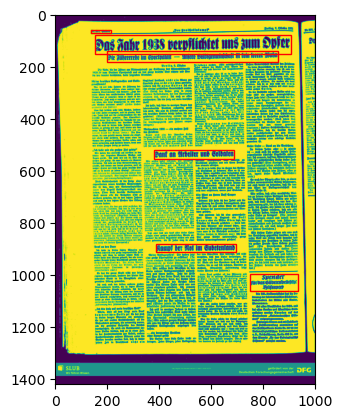

In [66]:
import numpy as np

random_number = random.randint(0, 47)

image, categories, boxes = dataset[random_number]

image = image.numpy()   # Umwandeln des Tensors in ein numpy Array
image = np.transpose(image, (1, 2, 0))  # Neuanordnen der Dimensionen des Arrays

fig, ax = plt.subplots(1)   # Erstellen einer Figur
ax.set_xlim(0, image.shape[1]) # Setzen der Grenzen der x-Achse
ax.set_ylim(image.shape[0],0) # Setzen der Grenzen der y-Achse
ax.imshow(image)    # Anzeigen des Bildes

for box in boxes:
    patch = patches.Rectangle(((box[0]*1000), (box[1]*1421)), (box[2]*1000), (box[3]*1421), linewidth=1, edgecolor='r', facecolor='none') # Nach der Normalisierung der Bounding Boxen müssen diese wieder in die ursprüngliche Größe gebracht werden

    # Fügen Sie die Patch zur Achse hinzu
    ax.add_patch(patch)

# Anzeigen der Figur
print("Bild " + str(random_number+1))
plt.show()

Der nachstehende Code überprüft, ob es Werte im Box-Tensor gibt, die außerhalb von 0 und 1 liegen.

Da der Code jedoch keine Meldung ausgibt, scheinen die Werte grundsätzlich korrekt normalisiert worden zu sein.

In [51]:
# Überprüfen Sie, ob alle Werte in den Bounding-Boxen zwischen 0 und 1 liegen
assert (boxes >= 0).all() and (boxes <= 1).all(), "Es gibt Werte außerhalb des Bereichs [0, 1] in den Bounding-Boxen"

# Überprüfen Sie, ob die Breite und Höhe aller Bounding-Boxen größer als 0 sind
assert (boxes[:, 2] > 0).all() and (boxes[:, 3] > 0).all(), "Es gibt Bounding-Boxen mit Breite oder Höhe <= 0"

## Split in Trainings- und Testdaten

Nun kann das Dataset in Trainings- und Testdaten aufgeteilt werden. Hierfür wird wird eine Liste `indices` mit dem Index der 48 Bilder erstellt. Diese wird mithilfe der `train_test_split`-Methode in trainings- und Testdaten im Verhältnis 0,8:0,2 aufgeteilt. Anschließend werden mit der `Subset`-Methode von PyTorch die Subsets `train_dataset` und `test_dataset` entsprechend des Splits gebildet.

`torch.manual_seed(42)` setzt einen Seed, der den zufälligen Split reproduzierbar macht.

In [52]:
from sklearn.model_selection import train_test_split    #zum Aufteilen des datasets in Trainigs- und Testdaten
from torch.utils.data import Subset       #zum Erstellen der train- und test-Subsets

torch.manual_seed(42)

# Erstellen Sie Indizes für das Training und das Testen
indices = list(range(len(dataset)))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

# Erstellen der PyTorch-Subsets
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

print(f"Trainingsset Größe: {len(train_dataset)}")
print(f"Testset Größe: {len(test_dataset)}")

Trainingsset Größe: 38
Testset Größe: 10


## Dataloader

Theoretisch müssen die Trainings- und Testdaten nur noch in den Dataloader geladen werden. Wird jedoch der folgende Code mit einer `batch_size > 1` ausgeführt, taucht ein überwunden geglaubtes Problem wieder auf. Eine Fehlermeldung erscheint, die darauf hinweist, dass die Tensoren nicht die gleiche Größe haben.

Im Normalfall werden die Daten in Form von Batches an die Modelle übergeben. Batches sind eine Art von Datenpaketen, in denen mehrere Bilder zusammengefasst von dem Netzwerk verarbeitet werden. Hier wirken sich allerdings wieder die Annotationen aus, die mit ihrer unterschiedlichen Anzahl zu ungleich großen Tensoren führen.

Der Dataloader darf also maximal ein Bild mit Annotationen auf einmal laden. Dabei ist die Batchgröße kein Wert, der willkürlich festgelegt werden sollte, schon gar nicht auf 1. Batches entscheiden darüber, wie oft sich das Netzwerk beim Lernen aktualisiert. Ist der Wert auf eins gesetzt, geschieht dies nach jedem Bild. Was zu übermäßigem Rauschen führen kann. Das Modell verändert sich anhand jedes Bildes, wodurch es möglicherweise langsamer konvergiert.

Unabhängig davon ist aber die erzwungene Festlegung der Batches auf 1 allein schon deshalb problematisch, weil sie das Experimentieren mit unterschiedlichen Werten verhindert. Ein wesentlicher Teil des maschinellen Lernens.

Daher muss an dieser Stelle wohl eingeräumt werden, dass dem Padding in zukünftigen Ansätzen doch eine Chance gegeben werden muss. Denn auch wenn bis zu diesem Punkt viel Aufwand in einen Workaround investiert wurde, sind die eingegangenen Kompromisse ab diesem Punkt zu groß.

Für diesen Versuch wird dennoch mit `batch_size=1` weitergearbeitet.

In [127]:
from torch.utils.data import DataLoader

# Erstellen der dataloader
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Überprüfen des ersten Batches
images, labels, boxes = next(iter(train_loader))
print(f"Batch Größe: {len(images)}")
#images, labels, boxes
images.shape, labels.shape, boxes.shape


Batch Größe: 1


(torch.Size([1, 1, 1421, 1000]), torch.Size([1, 21]), torch.Size([1, 21, 4]))

## Modellerstellung

In [116]:
import torch.nn as nn
import torch.nn.functional as F


In [120]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)  # 1 Eingabekanal, 6 Ausgabekanäle, 5x5 Kernel
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 Max-Pooling
        self.conv2 = nn.Conv2d(6, 16, 5)  # 6 Eingabekanäle, 16 Ausgabekanäle, 5x5 Kernel
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # An diese Werte müssen Sie anpassen
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 21)  # 21 Ausgabeklassen

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)  # An diese Werte müssen Sie anpassen
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [121]:
torch.manual_seed(42)

model = Model()

In [122]:
import pandas as pd

In [ ]:
url = '' 
